# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [3]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.11089792939827

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [5]:
from tqdm import tqdm

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """

    n = X.shape[0]
    predictions = np.zeros((num_runs, n))
    answers = np.zeros((num_runs, n))
    mask = np.zeros((num_runs, n))
    for i in tqdm(range(num_runs)):
        boostrap_indexes = np.random.choice(np.arange(n), size=n, replace=True)

        X_bootstrap = X[boostrap_indexes]
        y_bootstrap = y[boostrap_indexes]

        bag = set(np.arange(n))
        in_bag = set(boostrap_indexes)
        out_of_bag = list(bag - in_bag)

        regressor.fit(X_bootstrap, y_bootstrap)
        mask[i, out_of_bag] = 1
        predictions[i, out_of_bag] = regressor.predict(X[out_of_bag])
        answers[i, out_of_bag] = y[out_of_bag]

    ns = mask.sum(axis=0)
    used_samples = np.nonzero(ns)[0]

    ns = ns[used_samples]
    predictions = predictions[:, used_samples]
    answers = answers[:, used_samples]
    mask = mask[:, used_samples]
    
    mean_predictions = np.sum(predictions, axis=0)/ns
    mean_answers = np.sum(answers, axis=0)/ns
    bias = np.mean(np.square(mean_predictions - mean_answers))

    delta_predictions = np.square(predictions - mean_predictions)*mask
    mean_delta_predictions = np.sum(delta_predictions, axis=0)/ns
    variance = np.mean(mean_delta_predictions)

    errors = np.square(predictions - y)*mask
    mean_errors = np.sum(errors, axis=0)/ns
    error = np.mean(mean_errors)

    return bias, variance, error
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
linreg = LinearRegression()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()

linreg_bias, linreg_variance, linreg_error = compute_biase_variance(linreg, X, y)
tree_bias, tree_variance, tree_error = compute_biase_variance(tree, X, y)
forest_bias, forest_variance, forest_error = compute_biase_variance(forest, X, y)

print(f'linreg: bias={linreg_bias}, variance={linreg_variance}, error={linreg_error}')
print(f'tree: bias={tree_bias}, variance={tree_variance}, error={tree_error}')
print(f'forest: bias={forest_bias}, variance={forest_variance}, error={forest_error}')

__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Данные действительно согласуются, линейная регресия - имеет довольно маленькую дисперсию, потому что не так сильно подгоняется под обучающую выборку, но при этом сама модель не очень сильная, поэтому смещение большое. В случае решающего дерева, смещение уже меньше, потому что модель более сильная, однако дисперсия сильно выше, так как дерево сильно переобучается. В случае леса, смещение остается таким же как у дерева, что согласуется с теорией занятий, а дисперсия существенно падает, так как если бы деревья не были скореллированны, она могла бы упасть в число_деревьев раз, но деревья были скореллированны начиная с какого-то, поэтому не прям сильно она упала.

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ 
В теории беггинг уменьшает разброс в N раз и прибавляет еще число, зависящее от скореллированности базовых моделей, чем корреляция больше, тем эта добавка больше. В наших экспериментах N=10. Для линейной регрессии это не улучшило разброс, так как модели были сильно скореллированны. Решающие деревья же сильно уменьшили разброс, так как модели были плохо скореллированны, ведь дерево сильно подстраивается под обучающую выборку. В случае леса, обобщающая способность уже намного выше деревьев, поэтому базовые модели уже будут скореллированны и дисперсия сильно не уменьшается.

In [90]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor(LinearRegression())
linreg_bias, linreg_variance, linreg_error = compute_biase_variance(bagging, X = X, y = y)
bagging = BaggingRegressor(DecisionTreeRegressor())
tree_bias, tree_variance, tree_error = compute_biase_variance(bagging, X = X, y = y)
bagging = BaggingRegressor(RandomForestRegressor())
forest_bias, forest_variance, forest_error = compute_biase_variance(bagging, X = X, y = y)

print(f'linreg: bias={linreg_bias}, variance={linreg_variance}, error={linreg_error}')
print(f'tree: bias={tree_bias}, variance={tree_variance}, error={tree_error}')
print(f'forest: bias={forest_bias}, variance={forest_variance}, error={forest_error}')

100%|██████████| 1000/1000 [27:12<00:00,  1.63s/it]

linreg: bias=23.705599766865895, variance=1.0276245015402399, error=24.73322426840614
tree: bias=10.59075511804311, variance=3.363224063394568, error=13.95397918143768
forest: bias=11.55580158213826, variance=1.4141906281767012, error=12.969992210314965


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
from sklearn.model_selection import train_test_split

def plot_predictions(ax, regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    
    n = X_train.shape[0]

    for i in tqdm(range(num_runs)):
        bootstrap_indexes = np.random.choice(np.arange(n), size=n, replace=True)
        X_bootstrap = X_train[bootstrap_indexes]
        y_bootstrap = y_train[bootstrap_indexes]

        regressor.fit(X_bootstrap, y_bootstrap)
        prediction = regressor.predict(X_test)

        ax.scatter(np.arange(num_test_objects), prediction, color = 'aqua')
    
    ax.scatter(np.arange(num_test_objects), y_test, color = 'red', label = 'target')
    ax.set_title(title)
    ax.legend()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


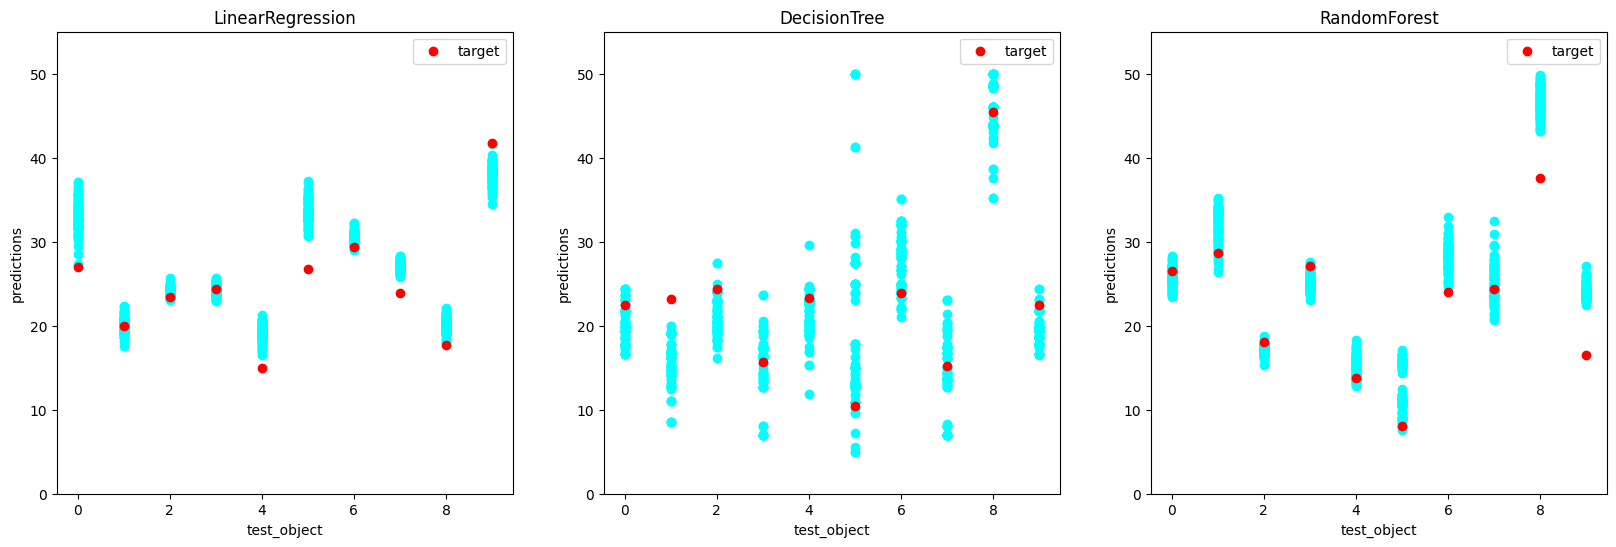

In [12]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=3, nrows=1)

axes[0].set_title('LinearRegression')
axes[1].set_title('DecisionTree')
axes[2].set_title('RandomForest')

axes[0].set_ylim([0, 55])
axes[1].set_ylim([0, 55])
axes[2].set_ylim([0, 55])

for ax in axes:
    ax.set_xlabel('test_object')

for ax in axes:
    ax.set_ylabel('predictions')

plot_predictions(axes[0], linreg, X, y, title='LinearRegression')
plot_predictions(axes[1], tree, X, y, title='DecisionTree')
plot_predictions(axes[2], forest, X, y, title='RandomForest')

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

На графике для LinerRegression, разброс небольшой по сравнению с DecisionTree, однако смещение уже больше чем у других моделей, что согласуется с полученными веше результатами. У DecisionTree видно что красная точка лежит более близко к центра голубых точек, но при этом разброс стал намного выше. RandomForest содердит плюсы обоих моделей, все ответы достаточно близки и при этом красная точка не далека от центра этих ответов, что опять согласуется с теорией.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [103]:
list_max_depth = np.arange(1, 10+1)

depth_biases = []
depth_variances = []

for max_depth in list_max_depth:
    tree = DecisionTreeRegressor(max_depth=max_depth)
    bias, variance, _ = compute_biase_variance(tree, X, y)
    depth_biases.append(bias)
    depth_variances.append(variance)

100%|██████████| 1000/1000 [00:02<00:00, 348.64it/s]


In [113]:
list_max_features = np.arange(1, X.shape[1]+1)

features_biases = []
features_variances = []

for max_features in list_max_features:
    tree = DecisionTreeRegressor(max_features=max_features)
    bias, variance, _ = compute_biase_variance(tree, X, y)
    features_biases.append(bias)
    features_variances.append(variance)

100%|██████████| 1000/1000 [00:03<00:00, 301.39it/s]


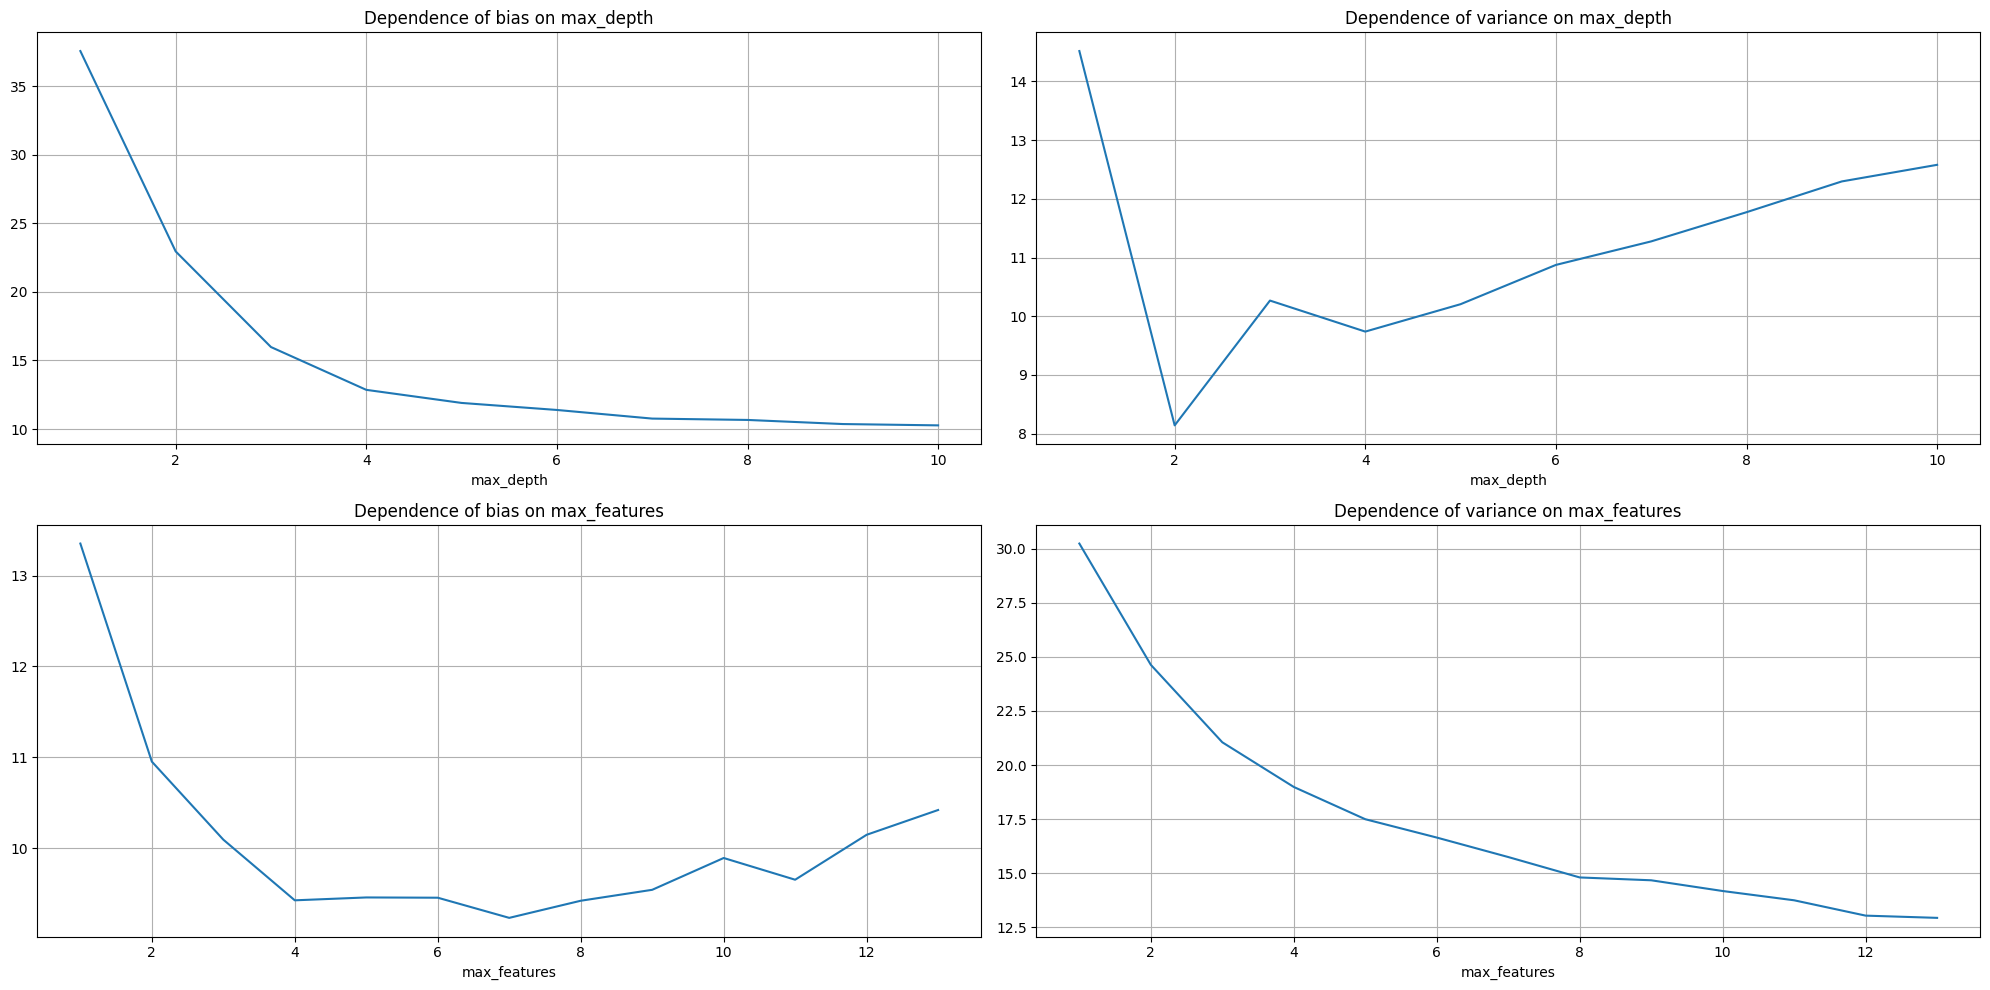

In [115]:
fig, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=2)


axes[0][0].set_title("Dependence of bias on max_depth")
axes[0][1].set_title("Dependence of variance on max_depth")

axes[1][0].set_title("Dependence of bias on max_features")
axes[1][1].set_title("Dependence of variance on max_features")

axes[0][0].set_xlabel("max_depth")
axes[0][1].set_xlabel("max_depth")

axes[1][0].set_xlabel("max_features")
axes[1][1].set_xlabel("max_features")

axes[0][0].plot(list_max_depth, depth_biases)
axes[0][1].plot(list_max_depth, depth_variances)

axes[1][0].plot(list_max_features, features_biases)
axes[1][1].plot(list_max_features, features_variances)

for ax in axes.ravel():
    ax.grid()
    
plt.tight_layout()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [117]:
list_n_estimators = np.logspace(1, 10, num = 10, base=2.0).astype(int)

forest_biases = []
forest_variances = []

for n_estimators in list_n_estimators:
    forest = RandomForestRegressor(n_estimators = n_estimators)
    bias, variance, _ = compute_biase_variance(forest, X, y)
    forest_biases.append(bias)
    forest_variances.append(variance)

100%|██████████| 1000/1000 [40:27<00:00,  2.43s/it]


In [120]:
from sklearn.ensemble import GradientBoostingRegressor

list_n_estimators = np.logspace(1, 10, num = 10, base=2.0).astype(int)

boosting_biases = []
boosting_variances = []

for n_estimators in list_n_estimators:
    boosting = GradientBoostingRegressor(n_estimators = n_estimators)
    bias, variance, _ = compute_biase_variance(forest, X, y)
    boosting_biases.append(bias)
    boosting_variances.append(variance)

100%|██████████| 1000/1000 [17:05<00:00,  1.03s/it]


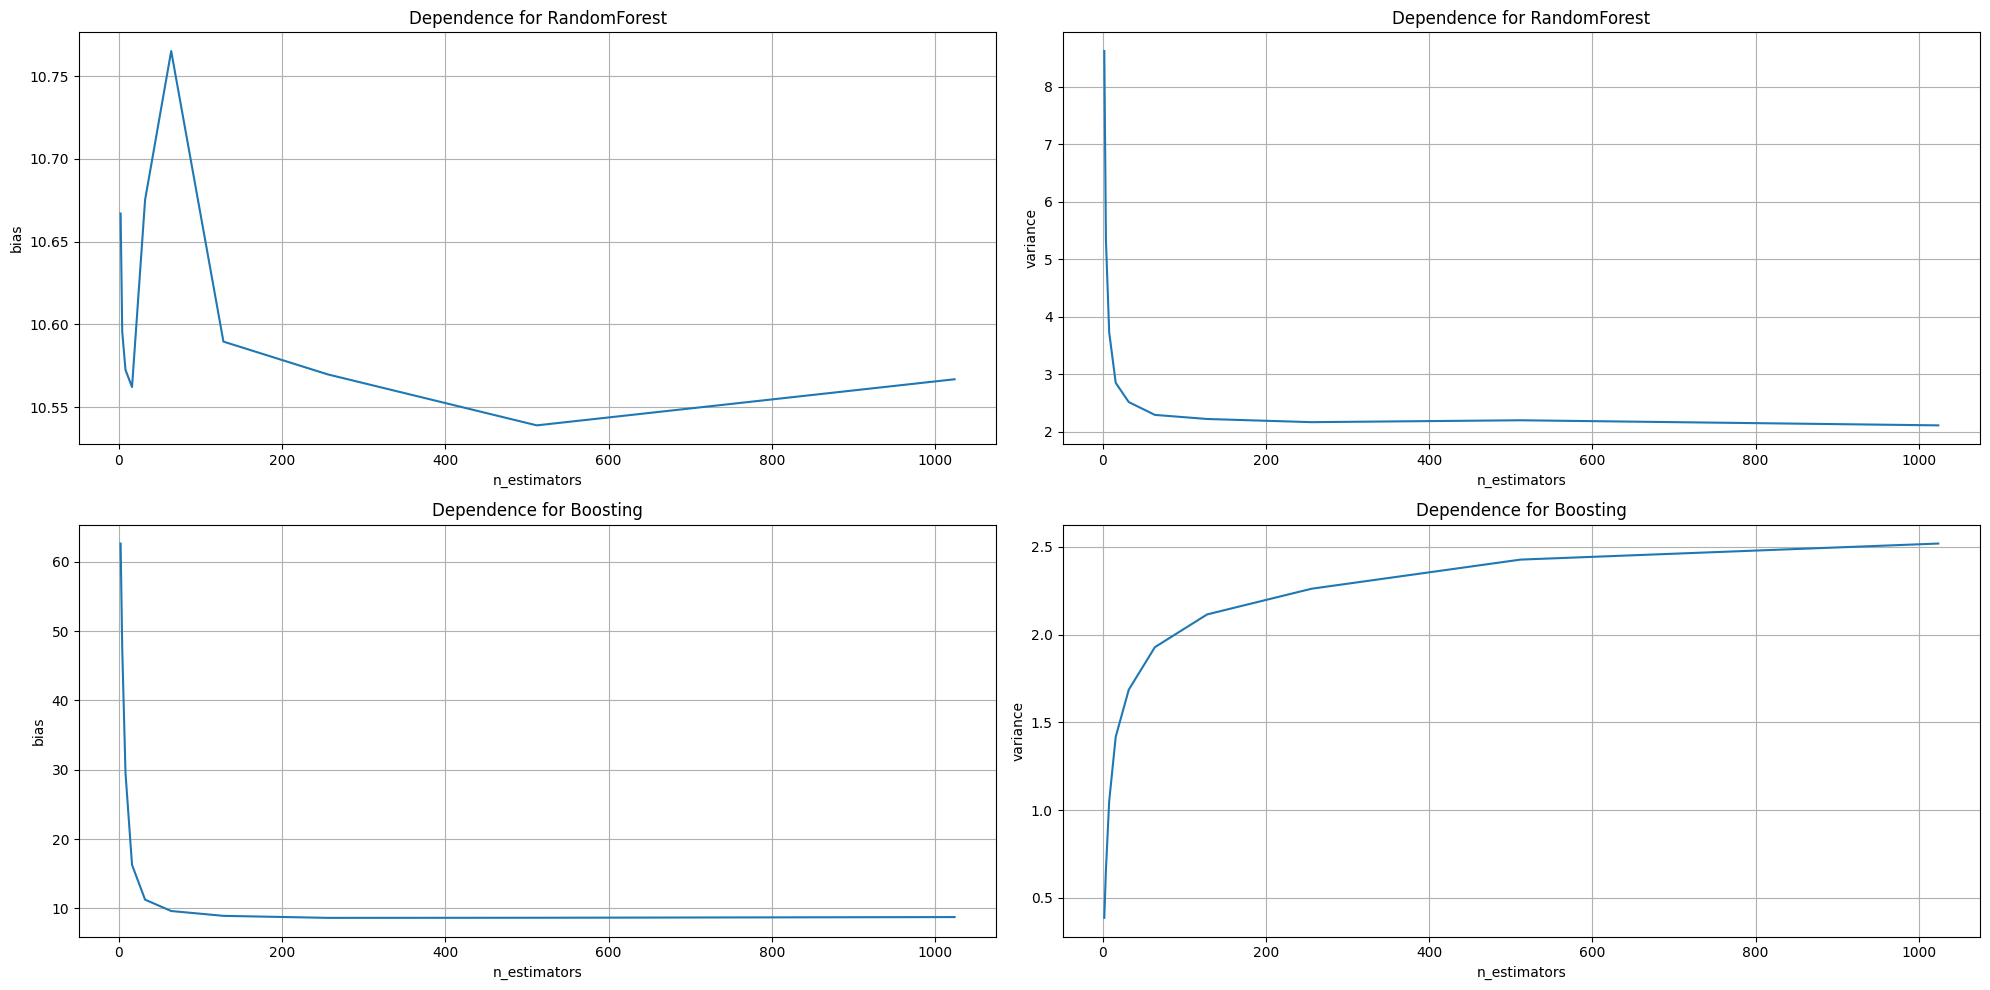

In [126]:
fig, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=2)

axes[0][0].set_title("Dependence for RandomForest")
axes[0][1].set_title("Dependence for RandomForest")

axes[1][0].set_title("Dependence for Boosting")
axes[1][1].set_title("Dependence for Boosting")

axes[0][0].set_ylabel("bias")
axes[0][1].set_ylabel("variance")

axes[1][0].set_ylabel("bias")
axes[1][1].set_ylabel("variance")

axes[0][0].set_xlabel("n_estimators")
axes[0][1].set_xlabel("n_estimators")

axes[1][0].set_xlabel("n_estimators")
axes[1][1].set_xlabel("n_estimators")

axes[0][0].plot(list_n_estimators, forest_biases)
axes[0][1].plot(list_n_estimators, forest_variances)

axes[1][0].plot(list_n_estimators, boosting_biases)
axes[1][1].plot(list_n_estimators, boosting_variances)

for ax in axes.ravel():
    ax.grid()
    
plt.tight_layout()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

- DecisionTree(max_depth): с увеличением max_depth, модель становится более сильной, поэтому bias падает, однако с увеличением max_depth модель становится более переобученной, поэтому разброс увеличивается.

- DecisionTree(max_features): при увеличении max_features, у модели появляется больше выбора признаков, по которым можно делать оптимальный split, из-за чего модель становится более сильной и смещение падает до какого-то момента. Разброс тоже падает с увеличением max_features, так как когда дерево выбирает признак по которому делать сплит, то у двух деревьев он совпадет более вероятно, когда число доступных сплитов больше (если доступен только 1 сплит, то скорее всего у разных деревьев они не будут пересекаться), поэтому с ростом max_features модели становятся более схожими, а значит и падает разброс.

- RandomForest(n_estimators): видно что смещение не зависит от n_estimators, значения очень незначительно отличаются, что согласуется с материалами лекций. Дисперсия на графике тоже сначала сильно падает, вероятно линейно от n_estimators, а затем базовые модели становятся скореллированны и разброс не снижается, опять все согласуется.

- GradientBoosting(n_estimators): с ростом n_estimators, смещение падает, так как модель становится более сильной пока не выявляет всю информацию из обучающей выборки. Разброс же с ростом n_estimators увеличивается пока не достигнет значения 2.5, так как модель становится более переобученной.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️


__Your answer here:__